In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')

In [2]:
murders_full = pd.read_csv('C:\\Users\\Classy\\Desktop\\Springboard\\Murder Project\\Data\\SHR76_19.csv')

print(murders_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804751 entries, 0 to 804750
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            804751 non-null  object 
 1   CNTYFIPS      804751 non-null  object 
 2   Ori           804751 non-null  object 
 3   State         804751 non-null  object 
 4   Agency        804751 non-null  object 
 5   Agentype      804751 non-null  object 
 6   Source        804751 non-null  object 
 7   Solved        804751 non-null  object 
 8   Year          804751 non-null  int64  
 9   StateName     0 non-null       float64
 10  Month         804751 non-null  object 
 11  Incident      804751 non-null  int64  
 12  ActionType    804751 non-null  object 
 13  Homicide      804751 non-null  object 
 14  Situation     804751 non-null  object 
 15  VicAge        804751 non-null  int64  
 16  VicSex        804751 non-null  object 
 17  VicRace       804751 non-null  object 
 18  VicE

In [3]:
murders_short = murders_full.drop(['ID',
              'Source',
              'StateName',
              'Incident',
              'ActionType',
              'OffAge',
              'OffSex',
              'OffRace',
              'OffEthnic',
              'Relationship',
              'OffCount',
              'FileDate',
              'Circumstance',
              'Subcircum',
              'Year',
              'Agency',
              'State',
              'CNTYFIPS',
              ],
             axis=1)

In [4]:
murders_short.nunique()

Ori          12936
Agentype         7
Solved           2
Month           12
Homicide         2
Situation        6
VicAge         101
VicSex           3
VicRace          6
VicEthnic        3
Weapon          17
VicCount        13
MSA            409
dtype: int64

In [5]:
murders_short.Situation.value_counts()

Single victim/single offender           441743
Single victim/unknown offender(s)       213712
Single victim/multiple offenders         82068
Multiple victims/single offender         37796
Multiple victims/unknown offender(s)     18057
Multiple victims/multiple offenders      11375
Name: Situation, dtype: int64

In [6]:
#Adjusting 'Situation' to remove dependent variable leakage (but maybe still capture a meaningful feature):
murders_short['Situation'].replace(to_replace = ['Single victim/single offender',
                                           'Single victim/unknown offender(s)',
                                           'Single victim/multiple offenders'],
                             value = 'Single Victim',
                             inplace = True)

murders_short['Situation'].replace(to_replace = ['Multiple victims/single offender',
                                           'Multiple victims/unknown offender(s)',
                                           'Multiple victims/multiple offenders'],
                             value = 'Multiple Victims',
                             inplace = True)

In [7]:
murders_short.Situation.value_counts()

Single Victim       737523
Multiple Victims     67228
Name: Situation, dtype: int64

In [8]:
#Create Ori clearance rate column

clearance_rates = murders_short.groupby(['Ori','Solved'])['Month'].count()
clearance_rates = clearance_rates.unstack()
clearance_rates.fillna(0, inplace = True)
clearance_rates['Clearance'] = clearance_rates.Yes/(clearance_rates.Yes + clearance_rates.No)
clearance_dict = dict(zip(clearance_rates.index, clearance_rates.Clearance))
clearance_dict

murders_short['OriClearance'] = murders_short.Ori.apply(lambda x: clearance_dict.get(x))

Text(0, 0.5, 'Observations')

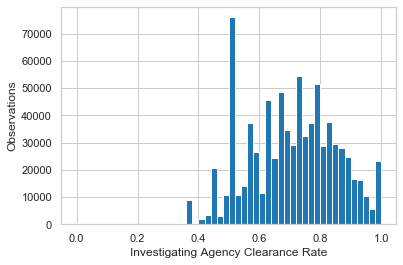

In [9]:
plt.hist(murders_short.OriClearance, bins = 50)
plt.xlabel('Investigating Agency Clearance Rate')
plt.ylabel('Observations')

In [10]:
#Create total cases handled column (to possibly capture experience level of investigators)
cases_handled = murders_short.groupby('Ori')['Solved'].count()
cases_dict = dict(zip(cases_handled.index, cases_handled))

murders_short['OriCases'] = murders_short.Ori.apply(lambda x: cases_dict.get(x))

Text(0, 0.5, 'Observations')

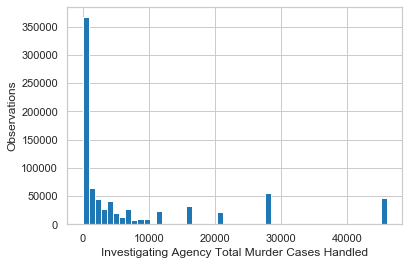

In [11]:
plt.hist(murders_short.OriCases, bins = 50)
plt.xlabel('Investigating Agency Total Murder Cases Handled')
plt.ylabel('Observations')

In [12]:
#Create White murder ratio column (perhaps to capture a feature for racial bias)

murders_by_race = murders_short.groupby(['Ori', 'VicRace'])['Solved'].count()
murders_by_race = murders_by_race.unstack()
murders_by_race.fillna(0, inplace = True)
murders_by_race['White/NonWhite Ratio'] = murders_by_race['White']/murders_by_race.sum(axis = 1)
race_dict = dict(zip(murders_by_race.index, murders_by_race['White/NonWhite Ratio']))

murders_short['WhiteNonWhiteRatio'] = murders_short.Ori.apply(lambda x: race_dict.get(x))

Text(0, 0.5, 'Observations')

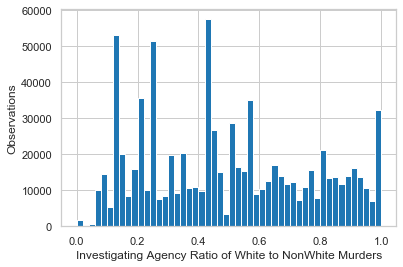

In [13]:
plt.hist(murders_short.WhiteNonWhiteRatio, bins = 50)
plt.xlabel('Investigating Agency Ratio of White to NonWhite Murders')
plt.ylabel('Observations')

The above columns should be generated a second time for the no_unknowns dataset after removing unknowns

In [14]:
#Create age known/unknown column
murders_short['AgeKnown'] = murders_short.VicAge.apply(lambda x: 0 if x == 999 else 1)

In [15]:
#Change unknown ages to mean
average_age = np.mean(murders_short.VicAge)
print(average_age)
murders_short.VicAge[murders_short.VicAge == 999] = average_age

47.72550391363291


C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
murders_short.VicAge.value_counts().sort_index()[45:50]

45.000000    10392
46.000000     9322
47.000000     8858
47.725504    12312
48.000000     8208
49.000000     7990
50.000000     8388
Name: VicAge, dtype: int64

In [17]:
#Merge firearm categories in 'Weapon' to condense features
murders_short.Weapon.value_counts()

Handgun - pistol, revolver, etc         394363
Knife or cutting instrument             117868
Firearm, type not stated                 68428
Personal weapons, includes beating       46269
Other or type unknown                    41648
Shotgun                                  39071
Blunt object - hammer, club, etc         35638
Rifle                                    30109
Strangulation - hanging                  10038
Fire                                      7769
Asphyxiation - includes death by gas      4954
Other gun                                 3102
Narcotics or drugs, sleeping pills        2538
Drowning                                  1503
Explosives                                 625
Poison - does not include gas              569
Pushed or thrown out window                259
Name: Weapon, dtype: int64

In [18]:
murders_short.Weapon.replace(to_replace = ['Handgun - pistol, revolver, etc',
                                           'Firearm, type not stated',
                                           'Shotgun',
                                           'Rifle',
                                           'Other gun'],
                             value = 'Gun',
                             inplace = True)
murders_short.Weapon.value_counts()

Gun                                     535073
Knife or cutting instrument             117868
Personal weapons, includes beating       46269
Other or type unknown                    41648
Blunt object - hammer, club, etc         35638
Strangulation - hanging                  10038
Fire                                      7769
Asphyxiation - includes death by gas      4954
Narcotics or drugs, sleeping pills        2538
Drowning                                  1503
Explosives                                 625
Poison - does not include gas              569
Pushed or thrown out window                259
Name: Weapon, dtype: int64

In [19]:
#Drop weird Victim Counts - documentation states maximum value in 'VicCount' should be 10
murders_short.VicCount.value_counts().sort_index()

0     737789
1      49032
2      10587
3       3772
4       1431
5        620
6        379
7        224
8        200
9        420
10       264
11        22
21        11
Name: VicCount, dtype: int64

In [20]:
murders_short = murders_short[murders_short.VicCount != 11]
murders_short = murders_short[murders_short.VicCount != 21]
murders_short.VicCount.value_counts().sort_index()

0     737789
1      49032
2      10587
3       3772
4       1431
5        620
6        379
7        224
8        200
9        420
10       264
Name: VicCount, dtype: int64

In [21]:
murders_short.nunique()

Ori                   12936
Agentype                  7
Solved                    2
Month                    12
Homicide                  2
Situation                 2
VicAge                  101
VicSex                    3
VicRace                   6
VicEthnic                 3
Weapon                   13
VicCount                 11
MSA                     409
OriClearance           1328
OriCases                542
WhiteNonWhiteRatio     1679
AgeKnown                  2
dtype: int64

In [22]:
#Export cleaned dataset with unknowns included
murders_short.drop('Ori', axis = 1).to_csv('C:\\Users\\Classy\\Desktop\\murders_short.csv')

In [23]:
#Create alternate dataset with all unknowns dropped

In [24]:
murders_short.Agentype.value_counts()

Municipal police    624346
Sheriff             136024
County police        22913
Primary state LE     19226
Special police        1513
Tribal                 357
Regional police        339
Name: Agentype, dtype: int64

In [25]:
sum(murders_short.MSA == 'Unknown')

0

In [26]:
sum(murders_short.Ori == 'Unknown')

0

In [27]:
murders_no_unknowns = murders_short[murders_short.VicAge != average_age]
print(sum(murders_no_unknowns.VicAge == average_age))

0


In [28]:
murders_short.VicSex.value_counts()

Male       623148
Female     180221
Unknown      1349
Name: VicSex, dtype: int64

In [29]:
murders_no_unknowns = murders_no_unknowns[murders_no_unknowns.VicSex != 'Unknown']
murders_no_unknowns.VicSex.value_counts()

Male      614553
Female    177478
Name: VicSex, dtype: int64

In [30]:
murders_short.VicRace.value_counts()

White                                  397633
Black                                  380396
Asian                                   11554
Unknown                                  8957
American Indian or Alaskan Native        6086
Native Hawaiian or Pacific Islander        92
Name: VicRace, dtype: int64

In [31]:
murders_no_unknowns = murders_no_unknowns[murders_no_unknowns.VicRace != 'Unknown']
murders_no_unknowns.VicRace.value_counts()

White                                  391892
Black                                  376123
Asian                                   11414
American Indian or Alaskan Native        6013
Native Hawaiian or Pacific Islander        92
Name: VicRace, dtype: int64

In [32]:
murders_short.Weapon.value_counts()

Gun                                     535040
Knife or cutting instrument             117868
Personal weapons, includes beating       46269
Other or type unknown                    41648
Blunt object - hammer, club, etc         35638
Strangulation - hanging                  10038
Fire                                      7769
Asphyxiation - includes death by gas      4954
Narcotics or drugs, sleeping pills        2538
Drowning                                  1503
Explosives                                 625
Poison - does not include gas              569
Pushed or thrown out window                259
Name: Weapon, dtype: int64

In [33]:
murders_no_unknowns = murders_no_unknowns[murders_no_unknowns.Weapon != 'Other or type unknown']
murders_no_unknowns.Weapon.value_counts()

Gun                                     524678
Knife or cutting instrument             115321
Personal weapons, includes beating       44907
Blunt object - hammer, club, etc         34750
Strangulation - hanging                   9735
Fire                                      7413
Asphyxiation - includes death by gas      4770
Narcotics or drugs, sleeping pills        2451
Drowning                                  1451
Explosives                                 616
Poison - does not include gas              555
Pushed or thrown out window                257
Name: Weapon, dtype: int64

In [34]:
murders_short.VicEthnic.value_counts()

Unknown or not reported    479154
Not of Hispanic origin     241188
Hispanic origin             84376
Name: VicEthnic, dtype: int64

Unfortunately, the 'VicEthnic' feature contains an enormous number of unknowns - over half the original dataset

For now, I will create one no_unknowns dataset that includes 'VicEthnic' unknowns and one that excludes them

In [35]:
murders_no_unknowns.to_csv('C:\\Users\\Classy\\Desktop\\murders_no_unknowns_except_VicEthnic.csv')

In [36]:
murders_no_unknowns = murders_no_unknowns[murders_no_unknowns.VicEthnic != 'Unknown or not reported']
murders_no_unknowns.VicEthnic.value_counts()

Not of Hispanic origin    228918
Hispanic origin            80043
Name: VicEthnic, dtype: int64

In [37]:
murders_no_unknowns.to_csv('C:\\Users\\Classy\\Desktop\\murders_no_unknowns.csv')